<a href="https://colab.research.google.com/github/taravatp/cats_vs_dogs/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/cats_vs_dogs/

/content/drive/MyDrive/cats_vs_dogs


In [ ]:
!pip install import_ipynb 

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=cfb69ac3a1755d076e69e0736ee5e6d0f775813d37aee5002fef81cc7e52584b
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


importing Jupyter notebook from dataset.ipynb


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


importing Jupyter notebook from model_vgg16.ipynb


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


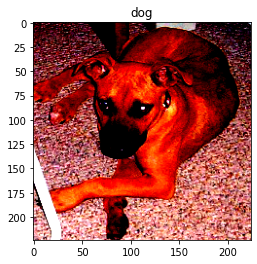

In [ ]:
import torch
import torch.nn as nn
import import_ipynb
from torchvision import models
import dataset
from torch.utils.data import Dataset,DataLoader
from dataset import vgg_dataset
import time
import numpy as np
from model_vgg16 import VGG16

In [ ]:
!pip install torch_summary
from torchsummary import summary

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Loading data

In [ ]:
train_root = '/content/drive/MyDrive/cats_vs_dogs/training_set/training_set'
valid_root =  '/content/drive/MyDrive/cats_vs_dogs/test_set/test_set'
train_set = vgg_dataset(dataset_path=train_root)
valid_set = vgg_dataset(dataset_path=valid_root)

batch_size = 32
data_loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True) 
data_loader_valid = DataLoader(valid_set, batch_size=batch_size, shuffle=True, drop_last=True) 

# defining model - optimizer and loss function

In [ ]:
model = VGG16(2).to(device)

In [ ]:
print(summary(model))

In [ ]:
loss_function = nn.BCELoss()
learning_rate = 1e-12
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
print(learning_rate)

1e-12


# training and validating

In [ ]:
num_epochs = 5
train_total_loss, train_total_accuracy, valid_total_accuracy= [],[],[]
for epoch in range(num_epochs):
  train_epoch_loss,train_epoch_accuracy,valid_epoch_accuracy=[],[],[] 
  model.train()
  time_start = time.time()

  for iteration,batch in enumerate(iter(data_loader_train)):
    input_image , label = batch
    prediction = model(input_image)
    batch_loss = loss_function(prediction,label)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_epoch_loss.append(batch_loss.item())

  for iteration,batch in enumerate(iter(data_loader_train)):
    model.eval()
    input_image , label = batch
    prediction = model(input_image)
    is_correct = ((prediction>0.5) == label).cpu().numpy().tolist()
    train_epoch_accuracy.extend(is_correct)
  
  for iteration,batch in enumerate(iter(data_loader_valid)):
    model.eval()
    input_image , label = batch
    prediction = model(input_image)
    is_correct = ((prediction>0.5) == label).cpu().numpy().tolist()
    valid_epoch_accuracy.extend(is_correct)

  train_total_loss.append(np.array(train_epoch_loss).mean())
  train_total_accuracy.append(np.mean(train_epoch_accuracy))
  valid_total_accuracy.append(np.mean(valid_epoch_accuracy))

  print("Finished epoch[{}], time elapsed[{}]".format(epoch, time.time() - time_start))
  torch.save(model.state_dict(), f"model{epoch}_batch_{batch_size}.pth")


Finished epoch[0], time elapsed[71.53293681144714]
Finished epoch[1], time elapsed[71.39613699913025]
Finished epoch[2], time elapsed[70.76515460014343]
Finished epoch[3], time elapsed[70.91024398803711]
Finished epoch[4], time elapsed[71.79338598251343]


In [ ]:
print(train_total_loss)
print(train_total_accuracy)
print(valid_total_accuracy)

[0.6931971484614957, 0.6932223631489661, 0.6933319241769852, 0.6931409412814725, 0.6935936424040026]
[0.5020161290322581, 0.501008064516129, 0.501008064516129, 0.5, 0.5]
[0.49899193548387094, 0.5, 0.49899193548387094, 0.49798387096774194, 0.5020161290322581]


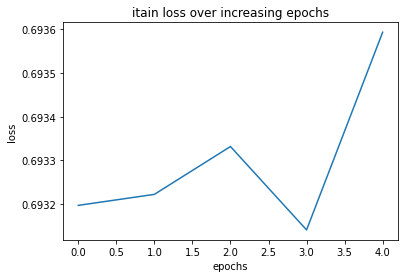

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('itain loss over increasing epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(train_total_loss)

Text(0.5, 1.0, 'validation set accuracy over increasing epochs')

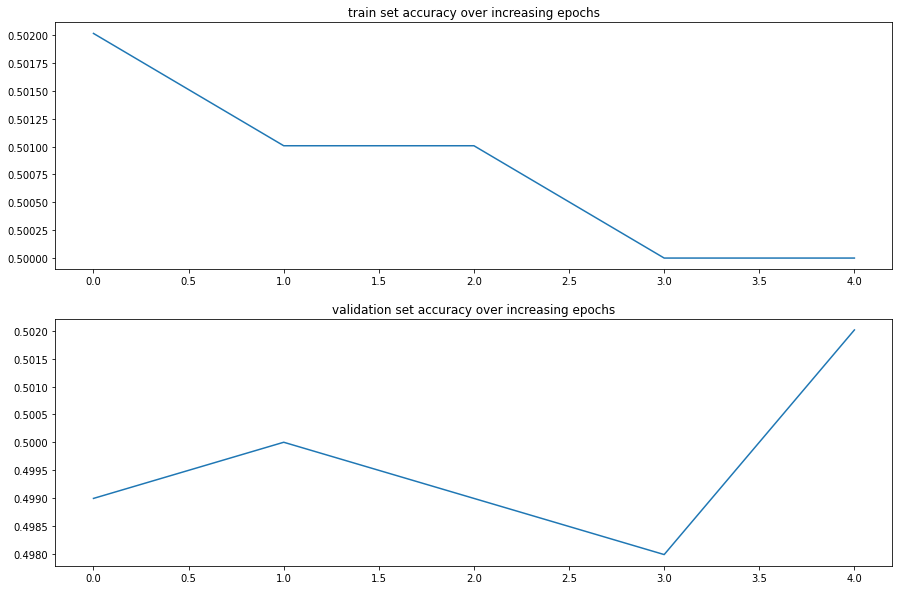

In [ ]:
figure, axis = plt.subplots(2,figsize=(15,10))
axis[0].plot(train_total_accuracy)
axis[0].set_title('train set accuracy over increasing epochs')
axis[1].plot(valid_total_accuracy)
axis[1].set_title('validation set accuracy over increasing epochs')